In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("PySpark Online Retail Analysis") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

In [2]:
import pandas as pd
import numpy as np

df_dtypes = {'Invoice': object, 'StockCode': object, 'Description': object, 'Quantity': np.int32,
             'InvoiceDate': np.datetime64, 'Price': np.float64, 'CustomerID': object, 'Country': object}

df = pd.concat([pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010'), 
                pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')], ignore_index=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
Invoice        1067371 non-null object
StockCode      1067371 non-null object
Description    1062989 non-null object
Quantity       1067371 non-null int64
InvoiceDate    1067371 non-null datetime64[ns]
Price          1067371 non-null float64
Customer ID    824364 non-null float64
Country        1067371 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


Two columns, Description and Customer ID, contain missing values. These will be replaced after the dataframe is read into PySpark.

In [3]:
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, FloatType, TimestampType, IntegerType, DoubleType

spark_Schema = StructType([StructField("Invoice", StringType(), False),
                           StructField("StockCode", StringType(), False),
                           StructField("Description", StringType(), True),
                           StructField("Quantity", IntegerType(), False),
                           StructField("InvoiceDate", TimestampType(), False),
                           StructField("Price", FloatType(), False),
                           StructField("CustomerID", StringType(), True), 
                           StructField("Country", StringType(), False)])

df = spark.createDataFrame(df, schema=spark_Schema)

In [5]:
df.printSchema()

root
 |-- Invoice: string (nullable = false)
 |-- StockCode: string (nullable = false)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = false)
 |-- InvoiceDate: timestamp (nullable = false)
 |-- Price: float (nullable = false)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = false)



In [5]:
# None Provided replaces missing values in Description. 0 replaces missing values in CustomerID
df = df.withColumn('Description', F.when(F.isnan(F.col('Description')), 'None Provided').otherwise(F.col('Description')))
df = df.withColumn('CustomerID', F.when(F.isnan(F.col('CustomerID')), '0').otherwise(F.col('CustomerID')))

In [7]:
# Sample of invoices with missing CustomerID 
df.filter(df["CustomerID"] == '0').sample(False, 0.0002, 999).show()

+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+
| 490149|    84378|SET OF 3 HEART CO...|       3|2009-12-04 09:43:00| 2.57|         0|United Kingdom|
| 492303|    35954|SMALL FOLKART STA...|       5|2009-12-16 11:57:00| 3.43|         0|United Kingdom|
| 493073|    22059|CERAMIC STRWBERRY...|       1|2009-12-22 09:41:00| 3.43|         0|United Kingdom|
| 493261|      DOT|      DOTCOM POSTAGE|       1|2009-12-22 14:48:00|88.48|         0|United Kingdom|
| 494495|    20759|CHRYSANTHEMUM POC...|       6|2010-01-14 17:43:00| 0.64|         0|United Kingdom|
| 497584|        M|              Manual|       2|2010-02-10 15:10:00| 1.65|         0|United Kingdom|
| 498861|    21780|       None Provided|     -25|2010-02-23 12:23:00|  0.0|       

In [8]:
# Grand total of products purchased with missing CustomerID
df.where((df["CustomerID"] == '0') & (df["Price"] > '0')) \
.withColumn('Total', df.Quantity*df.Price).agg(F.round(F.sum('Total'), 2).alias('Customer ID 0 Total')).show()

+-------------------+
|Customer ID 0 Total|
+-------------------+
|         2797634.31|
+-------------------+



In [9]:
# Preview of products "given out for free" with missing CustomerID
df.filter((df["CustomerID"] != '0') & (df["Price"] == '0')).show()

+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+
| 489825|    22076|  6 RIBBONS EMPIRE  |      12|2009-12-02 13:34:00|  0.0|   16126.0|United Kingdom|
| 489998|    48185| DOOR MAT FAIRY CAKE|       2|2009-12-03 11:19:00|  0.0|   15658.0|United Kingdom|
| 490727|        M|              Manual|       1|2009-12-07 16:38:00|  0.0|   17231.0|United Kingdom|
| 490961|    22065|CHRISTMAS PUDDING...|       1|2009-12-08 15:25:00|  0.0|   14108.0|United Kingdom|
| 490961|    22142|CHRISTMAS CRAFT W...|      12|2009-12-08 15:25:00|  0.0|   14108.0|United Kingdom|
| 492079|    85042|ANTIQUE LILY FAIR...|       8|2009-12-15 13:49:00|  0.0|   15070.0|United Kingdom|
| 492760|    21143|ANTIQUE GLASS HEA...|      12|2009-12-18 14:22:00|  0.0|   1807

In [10]:
# Total number of rows of products "given out for free" with missing CustomerID
df.filter((df["CustomerID"] != '0') & (df["Price"] == '0')).count()

71

In [11]:
# Rows with negative price
df.filter("Price < '0'").show()

+-------+---------+---------------+--------+-------------------+---------+----------+--------------+
|Invoice|StockCode|    Description|Quantity|        InvoiceDate|    Price|CustomerID|       Country|
+-------+---------+---------------+--------+-------------------+---------+----------+--------------+
|A506401|        B|Adjust bad debt|       1|2010-04-29 13:36:00|-53594.36|         0|United Kingdom|
|A516228|        B|Adjust bad debt|       1|2010-07-19 11:24:00|-44031.79|         0|United Kingdom|
|A528059|        B|Adjust bad debt|       1|2010-10-20 12:04:00|-38925.87|         0|United Kingdom|
|A563186|        B|Adjust bad debt|       1|2011-08-12 14:51:00|-11062.06|         0|United Kingdom|
|A563187|        B|Adjust bad debt|       1|2011-08-12 14:52:00|-11062.06|         0|United Kingdom|
+-------+---------+---------------+--------+-------------------+---------+----------+--------------+



In [12]:
# Total bad debt
df.filter("Price < '0'").agg(F.round(F.sum('Price'), 2).alias('Total Bad Debt')).show()

+--------------+
|Total Bad Debt|
+--------------+
|    -158676.14|
+--------------+



In [13]:
# Total rows with 0 value for Price
df.filter("Price = '0'").count()

6202

In [14]:
df.where("Price = '0' and Description = 'None Provided' and Quantity < '0'") \
.groupby(F.date_format('InvoiceDate', 'yyyy.MM').alias('date')).count().sort('date').show()

+-------+-----+
|   date|count|
+-------+-----+
|2009.12|   71|
|2010.01|  123|
|2010.02|  432|
|2010.03|  169|
|2010.04|   62|
|2010.05|  338|
|2010.06|  108|
|2010.07|   35|
|2010.08|   75|
|2010.09|   69|
|2010.10|   90|
|2010.11|  199|
|2010.12|  118|
|2011.01|   83|
|2011.02|   40|
|2011.03|   93|
|2011.04|  163|
|2011.05|   96|
|2011.06|   53|
|2011.07|  100|
+-------+-----+
only showing top 20 rows



In [15]:
df.where("Price = '0' and Description != 'None Provided' and Quantity < '0'") \
.groupby(F.date_format('InvoiceDate', 'yyyy.MM').alias('date')).count().sort('date').show()

+-------+-----+
|   date|count|
+-------+-----+
|2009.12|   19|
|2010.01|    5|
|2010.02|   16|
|2010.03|   21|
|2010.04|   13|
|2010.05|   31|
|2010.06|   32|
|2010.07|   53|
|2010.08|   18|
|2010.09|   24|
|2010.10|   28|
|2010.11|   26|
|2010.12|   16|
|2011.01|   13|
|2011.02|    8|
|2011.03|   41|
|2011.04|   23|
|2011.05|   21|
|2011.06|   54|
|2011.07|   17|
+-------+-----+
only showing top 20 rows



In [16]:
# Tally of Description with 0 value for Price and negative Quantity
df.where("Price = '0' and Description != 'None Provided' and Quantity < '0'") \
.groupby("Description").count().sort(F.col("count").desc()).show()

+--------------------+-----+
|         Description|count|
+--------------------+-----+
|               check|  123|
|             damages|   84|
|                   ?|   83|
|             damaged|   78|
|             missing|   27|
|sold as set on do...|   20|
|             Damaged|   17|
|             smashed|    9|
|Unsaleable, destr...|    9|
|         thrown away|    9|
|              dotcom|    8|
|            damages?|    7|
|                  ??|    7|
|             crushed|    6|
|          given away|    6|
|             counted|    5|
|                 MIA|    5|
|         wet damaged|    5|
|             checked|    5|
|             Damages|    5|
+--------------------+-----+
only showing top 20 rows



In [17]:
# Customer ID with the most entries with 0 value for price and negative quantity 
df.where("Price = '0' and Quantity < '0'") \
.groupby("CustomerID").count().sort(F.col("count").desc()).show()

+----------+-----+
|CustomerID|count|
+----------+-----+
|         0| 3457|
+----------+-----+



In [5]:
df1 = df.where(df["CustomerID"] != '0')
# New column with Item Total
df1 = df1.withColumn("ItemTotal", F.round(df1.Price*df1.Quantity, 2))

In [4]:
from pyspark.sql.window import Window
invoice_part = Window().partitionBy('Invoice')
# New column with Invoice Total
df1 = df1.withColumn('InvoiceTotal', F.round(F.sum('ItemTotal').over(invoice_part), 2))

In [9]:
df1.show(5)

+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|       Country|ItemTotal|InvoiceTotal|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
| 489677|    21341|KASBAH LANTERN WI...|      24|2009-12-02 09:50:00| 4.25|   14000.0|United Kingdom|    102.0|       192.0|
| 489677|    21323|HANGING MEDINA LA...|      24|2009-12-02 09:50:00| 3.75|   14000.0|United Kingdom|     90.0|       192.0|
| 491045|    71477|COLOUR GLASS. STA...|      48|2009-12-09 10:02:00| 2.75|   12747.0|United Kingdom|    132.0|       303.2|
| 491045|    21338|MARAKESH LANTERN ...|       6|2009-12-09 10:02:00| 5.95|   12747.0|United Kingdom|     35.7|       303.2|
| 491045|    21339|MARAKESH LANTERN ...|       4|2009-12-09 10:02:00|16.95|   12747.0|United Kingdom|     67.8|       303.2|


In [7]:
# All of the countries in the data
df1.createOrReplaceTempView("retail")
tab1 = spark.sql("SELECT DISTINCT Country FROM retail ORDER BY Country")
tab1.show(tab1.count())

+--------------------+
|             Country|
+--------------------+
|           Australia|
|             Austria|
|             Bahrain|
|             Belgium|
|              Brazil|
|              Canada|
|     Channel Islands|
|              Cyprus|
|      Czech Republic|
|             Denmark|
|                EIRE|
|  European Community|
|             Finland|
|              France|
|             Germany|
|              Greece|
|             Iceland|
|              Israel|
|               Italy|
|               Japan|
|               Korea|
|             Lebanon|
|           Lithuania|
|               Malta|
|         Netherlands|
|             Nigeria|
|              Norway|
|              Poland|
|            Portugal|
|                 RSA|
|        Saudi Arabia|
|           Singapore|
|               Spain|
|              Sweden|
|         Switzerland|
|            Thailand|
|                 USA|
|United Arab Emirates|
|      United Kingdom|
|         Unspecified|
|         W

In [22]:
# Tally of sales by Country
tab1 = spark.sql("SELECT Country, ROUND(SUM(ItemTotal), 2) AS TotalSale, COUNT(DISTINCT Invoice) AS NumberOfOrders \
                 FROM retail GROUP BY Country ORDER BY TotalSale DESC LIMIT 10")
tab1.show()

+--------------+-------------+--------------+
|       Country|    TotalSale|NumberOfOrders|
+--------------+-------------+--------------+
|United Kingdom|1.380642301E7|         40505|
|          EIRE|    578501.63|           727|
|   Netherlands|    548524.95|           250|
|       Germany|    417988.56|          1095|
|        France|    326504.67|           738|
|     Australia|    167129.07|           117|
|   Switzerland|     99082.81|           120|
|         Spain|     91859.48|           188|
|        Sweden|     87455.42|           128|
|       Denmark|     65741.09|            53|
+--------------+-------------+--------------+



In [23]:
# Top customers, Total Sale and Country
tab2 = spark.sql("SELECT CustomerID, ROUND(SUM(ItemTotal), 2) AS TotalSale, \
                 ROUND(SUM(ItemTotal)/COUNT(DISTINCT Invoice), 2) AS AverageSale, \
                 Country FROM retail GROUP BY CustomerID, Country ORDER BY TotalSale DESC LIMIT 25")
tab2.show(25)

+----------+---------+-----------+--------------+
|CustomerID|TotalSale|AverageSale|       Country|
+----------+---------+-----------+--------------+
|   18102.0|598215.22|     3909.9|United Kingdom|
|   14646.0|523342.07|    3191.11|   Netherlands|
|   14156.0|296564.69|    1468.14|          EIRE|
|   14911.0|270248.53|      529.9|          EIRE|
|   17450.0|233579.39|    3829.17|United Kingdom|
|   13694.0|190825.52|    1163.57|United Kingdom|
|   17511.0|171885.98|    2022.19|United Kingdom|
|   12415.0|143269.29|    4341.49|     Australia|
|   16684.0|141502.25|    2176.96|United Kingdom|
|   15061.0|136391.48|     988.34|United Kingdom|
|   15311.0|113513.07|     420.42|United Kingdom|
|   13089.0|113214.19|     458.36|United Kingdom|
|   17949.0| 98895.59|     716.63|United Kingdom|
|   16029.0| 91800.91|     734.41|United Kingdom|
|   14298.0| 90489.31|    1077.25|United Kingdom|
|   15769.0| 84269.38|    1652.34|United Kingdom|
|   13798.0| 73573.47|     588.59|United Kingdom|


In [24]:
# Top customer of each Country
tab3 = spark.sql("SELECT CustomerID AS TopCustomerID, Country, TotalSale, NumberOfOrders, ROUND(TotalSale/NumberOfOrders, 2) AS AverageSale FROM \
                 (SELECT CustomerID, RANK() OVER (PARTITION BY Country ORDER BY TotalSale DESC) AS Ordinal, TotalSale, NumberOfOrders, Country FROM \
                 (SELECT CustomerID, ROUND(SUM(ItemTotal), 2) AS TotalSale, COUNT(DISTINCT Invoice) AS NumberOfOrders, Country FROM retail GROUP BY Country, CustomerID) \
                 ORDER BY Ordinal, TotalSale DESC) WHERE Ordinal = 1")
tab3.show(tab3.count())

+-------------+--------------------+---------+--------------+-----------+
|TopCustomerID|             Country|TotalSale|NumberOfOrders|AverageSale|
+-------------+--------------------+---------+--------------+-----------+
|      18102.0|      United Kingdom|598215.22|           153|     3909.9|
|      14646.0|         Netherlands|523342.07|           164|    3191.11|
|      14156.0|                EIRE|296564.69|           202|    1468.14|
|      12415.0|           Australia|143269.29|            33|    4341.49|
|      17404.0|              Sweden| 46006.82|            28|     1643.1|
|      12471.0|             Germany| 37948.61|           129|     294.18|
|      12678.0|              France| 33851.13|            23|    1471.79|
|      13902.0|             Denmark| 30411.26|             8|    3801.41|
|      12409.0|         Switzerland| 23090.47|            13|    1776.19|
|      12540.0|               Spain| 22107.29|            36|     614.09|
|      12753.0|               Japan| 2

In [25]:
# All of the invoices of the top customer
tab4 = spark.sql("SELECT DISTINCT Invoice, InvoiceTotal, DATE_FORMAT(InvoiceDate, 'MM/yyyy') AS Date FROM retail WHERE CustomerID = 18102.0 ORDER BY InvoiceTotal DESC")
tab4.show(tab4.count())

+-------+------------+-------+
|Invoice|InvoiceTotal|   Date|
+-------+------------+-------+
| 537659|    31770.98|12/2010|
| 526934|    26007.08|10/2010|
| 515944|    22863.36|07/2010|
| 572209|     22206.0|10/2011|
| 517731|     21984.0|08/2010|
| 537657|    19278.24|12/2010|
| 494243|     18532.3|01/2010|
| 531866|    18122.17|11/2010|
| 556255|     16488.0|06/2011|
| 490059|     14475.0|12/2009|
| 566934|    13249.94|09/2011|
| 491456|     11016.0|12/2009|
| 555920|    10999.52|06/2011|
| 581457|    10363.82|12/2011|
| 556726|     8915.52|06/2011|
| 553368|     8895.66|05/2011|
| 516781|     8328.31|07/2010|
| 558775|      7786.0|07/2011|
| 572196|     7398.54|10/2011|
| 569343|     7298.76|10/2011|
| 566935|      6870.0|09/2011|
| 494244|      6711.0|01/2010|
| 493885|      6624.0|01/2010|
| 561655|      6591.6|07/2011|
| 498440|      6412.0|02/2010|
| 543379|     6155.72|02/2011|
| 503186|     6051.45|03/2010|
| 511335|     6007.68|06/2010|
| 509352|      5782.0|05/2010|
| 566931

In [26]:
# Units Per Transactions by Month/Year
tab5 = spark.sql("SELECT Month, Year, ROUND(SUM(TotalUnits)/COUNT(DISTINCT Invoice), 1) AS UnitsPerTransaction FROM \
                 (SELECT SUM(Quantity) AS TotalUnits, Invoice, YEAR(InvoiceDate) AS Year, Month(InvoiceDate) AS Month FROM retail GROUP BY YEAR(InvoiceDate), MONTH(InvoiceDate), Invoice) \
                 GROUP BY Year, Month ORDER BY Year, Month")
tab5.show(tab5.count())

+-----+----+-------------------+
|Month|Year|UnitsPerTransaction|
+-----+----+-------------------+
|   12|2009|              205.4|
|    1|2010|              283.3|
|    2|2010|              274.4|
|    3|2010|              261.7|
|    4|2010|              214.0|
|    5|2010|              209.1|
|    6|2010|              205.3|
|    7|2010|              186.6|
|    8|2010|              288.9|
|    9|2010|              232.3|
|   10|2010|              227.1|
|   11|2010|              203.1|
|   12|2010|              259.3|
|    1|2011|              217.9|
|    2|2011|              218.7|
|    3|2011|              212.5|
|    4|2011|              201.3|
|    5|2011|              198.9|
|    6|2011|              209.1|
|    7|2011|              228.1|
|    8|2011|              250.4|
|    9|2011|              258.7|
|   10|2011|              251.7|
|   11|2011|              217.1|
|   12|2011|              221.3|
+-----+----+-------------------+



In [27]:
# Average Sale by Month/Year
tab6 = spark.sql("SELECT MONTH(InvoiceDate) AS Month, YEAR(InvoiceDate) AS Year, ROUND(SUM(ItemTotal)/COUNT(DISTINCT Invoice), 2) AS AverageSale FROM retail GROUP BY Year, Month ORDER BY Year, Month")
tab6.show(tab6.count())

+-----+----+-----------+
|Month|Year|AverageSale|
+-----+----+-----------+
|   12|2009|     349.09|
|    1|2010|     410.46|
|    2|2010|     366.59|
|    3|2010|     333.51|
|    4|2010|     347.14|
|    5|2010|      316.7|
|    6|2010|     311.76|
|    7|2010|     328.54|
|    8|2010|     379.61|
|    9|2010|     382.67|
|   10|2010|     373.16|
|   11|2010|     360.85|
|   12|2010|     503.06|
|    1|2011|     384.36|
|    2|2011|     363.18|
|    3|2011|     358.22|
|    4|2011|     307.84|
|    5|2011|      350.6|
|    6|2011|     356.19|
|    7|2011|     360.48|
|    8|2011|      399.2|
|    9|2011|     448.24|
|   10|2011|     430.67|
|   11|2011|     366.95|
|   12|2011|      371.9|
+-----+----+-----------+



In [28]:
# Top selling product (Quantity) by Month/Year
tab7 = spark.sql("SELECT Month, Year, StockCode, Description, TotalUnits, Price FROM \
                (SELECT Month, Year, StockCode, Description, TotalUnits, Price, RANK() OVER(PARTITION BY Year, Month ORDER BY TotalUnits DESC) AS Ordinal FROM \
                (SELECT MONTH(InvoiceDate) AS Month, YEAR(InvoiceDate) AS Year, StockCode, Description, ROUND(SUM(ItemTotal)/SUM(Quantity), 2) AS Price, SUM(Quantity) AS TotalUnits FROM retail \
                 GROUP BY Year, Month, StockCode, Description ORDER BY Year, Month)) WHERE Ordinal = 1")
tab7.show(tab7.count())

+-----+----+---------+--------------------+----------+-----+
|Month|Year|StockCode|         Description|TotalUnits|Price|
+-----+----+---------+--------------------+----------+-----+
|   12|2009|   85123A|WHITE HANGING HEA...|      6204| 2.65|
|    1|2010|    20993|JAZZ HEARTS MEMO PAD|      9489|  0.1|
|    2|2010|    37410|BLACK AND WHITE P...|     19248|  0.1|
|    3|2010|    21091|SET/6 WOODLAND PA...|     13099| 0.11|
|    4|2010|    21212|PACK OF 72 RETRO ...|      5258| 0.47|
|    5|2010|    21982|PACK OF 12 SUKI T...|      5570| 0.48|
|    6|2010|    84077|WORLD WAR 2 GLIDE...|      5388|  0.2|
|    7|2010|    21212|PACK OF 72 RETRO ...|      4081| 0.51|
|    8|2010|    21088|SET/6 FRUIT SALAD...|      7131| 0.08|
|    9|2010|    17003| BROCADE RING PURSE |     13817| 0.19|
|   10|2010|    84568|GIRLS ALPHABET IR...|      6336| 0.18|
|   11|2010|    84347|ROTATING SILVER A...|     11474| 1.79|
|   12|2010|    84077|WORLD WAR 2 GLIDE...|      8883| 0.21|
|    1|2011|   85123A|WH

There are many products sold at a really low Price. Let's check out a few of these products.

In [29]:
tab7a = spark.sql("SELECT * FROM retail WHERE (StockCode = 84826) and (MONTH(InvoiceDate) = MONTH(DATE('2011-11-01'))) and (YEAR(InvoiceDate) = YEAR(DATE('2011-11-01')))")
tab7a.show()

+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|       Country|ItemTotal|InvoiceTotal|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
| 575336|    84826|ASSTD DESIGN 3D P...|       4|2011-11-09 13:58:00| 0.85|   14968.0|United Kingdom|      3.4|      147.59|
| 575337|    84826|ASSTD DESIGN 3D P...|       5|2011-11-09 14:11:00| 0.85|   17867.0|United Kingdom|     4.25|      224.67|
| 575337|    84826|ASSTD DESIGN 3D P...|       1|2011-11-09 14:11:00| 0.85|   17867.0|United Kingdom|     0.85|      224.67|
| 578841|    84826|ASSTD DESIGN 3D P...|   12540|2011-11-25 15:57:00|  0.0|   13256.0|United Kingdom|      0.0|         0.0|
| 575767|    84826|ASSTD DESIGN 3D P...|       1|2011-11-11 11:11:00| 0.85|   17348.0|United Kingdom|     0.85|      209.73|


In [30]:
tab7b = spark.sql("SELECT * FROM retail WHERE (StockCode = 21088) and (MONTH(InvoiceDate) = MONTH(DATE('2010-08-01'))) and (YEAR(InvoiceDate) = YEAR(DATE('2010-08-01')))")
tab7b.show()

+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|       Country|ItemTotal|InvoiceTotal|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
| 517861|    21088|SET/6 FRUIT SALAD...|       3|2010-08-02 14:07:00| 0.65|   13090.0|United Kingdom|     1.95|      190.12|
| 518505|    21088|SET/6 FRUIT SALAD...|    7128|2010-08-09 13:10:00| 0.08|   14277.0|        France|   570.24|    11880.84|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+



In [31]:
tab7c = spark.sql("SELECT * FROM retail WHERE (StockCode = 20993) and (MONTH(InvoiceDate) = MONTH(DATE('2010-01-01'))) and (YEAR(InvoiceDate) = YEAR(DATE('2010-01-01')))")
tab7c.show()

+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|       Country|ItemTotal|InvoiceTotal|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
| 493953|    20993|JAZZ HEARTS MEMO PAD|      48|2010-01-08 14:04:00| 0.19|   14327.0|United Kingdom|     9.12|      328.62|
| 494208|    20993|JAZZ HEARTS MEMO PAD|       1|2010-01-12 11:33:00| 0.85|   17945.0|United Kingdom|     0.85|       137.7|
| 493577|    20993|JAZZ HEARTS MEMO PAD|      48|2010-01-05 11:16:00| 0.19|   13557.0|United Kingdom|     9.12|      311.42|
| 495488|    20993|JAZZ HEARTS MEMO PAD|      12|2010-01-25 12:19:00| 0.85|   14911.0|          EIRE|     10.2|      627.43|
| 494644|    20993|JAZZ HEARTS MEMO PAD|       2|2010-01-17 12:12:00| 0.85|   16595.0|United Kingdom|      1.7|      519.18|


In [32]:
tab7d = spark.sql("SELECT * FROM retail WHERE (StockCode = 37410) and (MONTH(InvoiceDate) = MONTH(DATE('2010-02-01'))) and (YEAR(InvoiceDate) = YEAR(DATE('2010-02-01')))")
tab7d.show()

+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|       Country|ItemTotal|InvoiceTotal|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
| 499486|    37410|BLACK AND WHITE P...|      72|2010-02-28 13:42:00| 0.85|   15061.0|United Kingdom|     61.2|     1422.78|
| 498548|    37410|BLACK AND WHITE P...|      12|2010-02-19 17:40:00| 1.25|   17400.0|United Kingdom|     15.0|      976.01|
| 499456|    37410|BLACK AND WHITE P...|      12|2010-02-28 10:40:00| 1.25|   17819.0|United Kingdom|     15.0|       131.4|
| 497946|    37410|BLACK AND WHITE P...|   19152|2010-02-15 11:57:00|  0.1|   13902.0|       Denmark|   1915.2|     16973.1|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+


In [33]:
tab7e = spark.sql("SELECT * FROM retail WHERE (StockCode = 21091) and (MONTH(InvoiceDate) = MONTH(DATE('2010-03-01'))) and (YEAR(InvoiceDate) = YEAR(DATE('2010-03-01')))")
tab7e.show()

+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|       Country|ItemTotal|InvoiceTotal|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
| 500336|    21091|SET/6 WOODLAND PA...|       6|2010-03-07 13:48:00| 0.85|   17589.0|United Kingdom|      5.1|      619.04|
| 500133|    21091|SET/6 WOODLAND PA...|       4|2010-03-04 15:07:00| 0.85|   16329.0|United Kingdom|      3.4|      402.79|
| 499517|    21091|SET/6 WOODLAND PA...|      12|2010-03-01 09:58:00| 0.85|   12598.0|        France|     10.2|      629.39|
| 501652|    21091|SET/6 WOODLAND PA...|       1|2010-03-18 12:47:00| 0.85|   17841.0|United Kingdom|     0.85|      281.03|
| 501652|    21091|SET/6 WOODLAND PA...|       3|2010-03-18 12:47:00| 0.85|   17841.0|United Kingdom|     2.55|      281.03|


In [34]:
# Top selling products (Price) by Month/Year
tab8 = spark.sql("SELECT Month, Year, StockCode, Description, ROUND(ItemTotal, 2) AS ItemTotal, Quantity, ROUND(ItemTotal/Quantity, 2) AS UnitPrice FROM \
                (SELECT Month, Year, StockCode, Description, ItemTotal, RANK() OVER(PARTITION BY Year, Month ORDER BY ItemTotal DESC) AS Ordinal, Quantity FROM \
                (SELECT MONTH(InvoiceDate) AS Month, YEAR(InvoiceDate) AS Year, StockCode, Description, SUM(ItemTotal) AS ItemTotal, SUM(Quantity) AS Quantity FROM retail \
                 GROUP BY Year, Month, StockCode, Description ORDER BY Year, Month)) WHERE Ordinal = 1")
tab8.show(tab8.count())

+-----+----+---------+--------------------+---------+--------+---------+
|Month|Year|StockCode|         Description|ItemTotal|Quantity|UnitPrice|
+-----+----+---------+--------------------+---------+--------+---------+
|   12|2009|   85123A|WHITE HANGING HEA...| 16417.86|    6204|     2.65|
|    1|2010|   85123A|WHITE HANGING HEA...|  14223.4|    5380|     2.64|
|    2|2010|   85123A|WHITE HANGING HEA...|   7592.2|    2804|     2.71|
|    3|2010|   85123A|WHITE HANGING HEA...| 12540.62|    4718|     2.66|
|    4|2010|    22423|REGENCY CAKESTAND...|  12717.0|    1092|    11.65|
|    5|2010|   85123A|WHITE HANGING HEA...|  11704.4|    4384|     2.67|
|    6|2010|    22423|REGENCY CAKESTAND...| 14902.35|    1290|    11.55|
|    7|2010|    22423|REGENCY CAKESTAND...| 15168.75|    1321|    11.48|
|    8|2010|   85123A|WHITE HANGING HEA...|  11257.2|    4224|     2.67|
|    9|2010|    22423|REGENCY CAKESTAND...| 21332.85|    1867|    11.43|
|   10|2010|    22423|REGENCY CAKESTAND...| 20332.0

In [35]:
# Top 10 best sellers (Price)
tab8a = spark.sql("SELECT StockCode, Description, ROUND(SUM(ItemTotal), 2) AS ItemTotal, SUM(Quantity) AS Quantity, COUNT(DISTINCT CustomerID) AS NumberOfCustomers, COUNT(DISTINCT Invoice) AS NumberOfOrders FROM retail \
                    GROUP BY StockCode, Description ORDER BY ItemTotal DESC LIMIT 10")
tab8a.show()

+---------+--------------------+---------+--------+-----------------+--------------+
|StockCode|         Description|ItemTotal|Quantity|NumberOfCustomers|NumberOfOrders|
+---------+--------------------+---------+--------+-----------------+--------------+
|    22423|REGENCY CAKESTAND...| 269736.7|   23446|             1316|          3659|
|   85123A|WHITE HANGING HEA...|242700.51|   90008|             1494|          5021|
|   85099B|JUMBO BAG RED RET...|134845.16|   74564|              861|          2683|
|    84879|ASSORTED COLOUR B...|126354.18|   79434|             1012|          2669|
|     POST|             POSTAGE| 112249.1|    5078|              496|          1981|
|    47566|       PARTY BUNTING|102686.23|   23335|              894|          2100|
|    22086|PAPER CHAIN KIT 5...| 78366.93|   29001|              896|          1706|
|    79321|       CHILLI LIGHTS| 72229.34|   15591|              306|           942|
|    21137|BLACK RECORD COVE...| 67127.15|   19606|              

In [36]:
# Top 10 best sellers (Quantity)
tab8b = spark.sql("SELECT StockCode, Description, ROUND(SUM(ItemTotal), 2) AS ItemTotal, SUM(Quantity) AS TotalQuantity, COUNT(DISTINCT CustomerID) AS NumberOfCustomers, COUNT(DISTINCT Invoice) AS NumberOfOrders FROM retail \
                 WHERE Price > 0 AND Quantity > 0 GROUP BY StockCode, Description ORDER BY TotalQuantity LIMIT 10")
tab8b.show()

+---------+--------------------+---------+-------------+-----------------+--------------+
|StockCode|         Description|ItemTotal|TotalQuantity|NumberOfCustomers|NumberOfOrders|
+---------+--------------------+---------+-------------+-----------------+--------------+
|    21772|VINTAGE METAL CAK...|    12.75|            1|                1|             1|
|    22631|CIRCUS PARADE LUN...|     1.95|            1|                1|             1|
|   90014C|SILVER AND BLACK ...|     2.95|            1|                1|             1|
|    47569|ENGLISH ROSE DESI...|     2.55|            1|                1|             1|
|   48173A| DOOR MAT BLUE FLOCK|     6.75|            1|                1|             1|
|   90025B|BAROQUE BUTTERFLY...|     3.75|            1|                1|             1|
|   84845A|HOLLYHOCK SQUARE ...|     1.25|            1|                1|             1|
|    84626|CANDY STRIPE ROSE...|    45.95|            1|                1|             1|
|    35999

In [37]:
# Top 10 products that have the most returned
tab8c = spark.sql("SELECT StockCode, Description, SUM(Quantity) AS TotalQuantity, COUNT(DISTINCT CustomerID) AS NumberOfCustomers, COUNT(DISTINCT Invoice) AS NumberOfOrders FROM Retail \
                  WHERE Quantity < 0 GROUP BY StockCode, Description ORDER BY NumberOfCustomers DESC, TotalQuantity LIMIT 10")
tab8c.show()

+---------+--------------------+-------------+-----------------+--------------+
|StockCode|         Description|TotalQuantity|NumberOfCustomers|NumberOfOrders|
+---------+--------------------+-------------+-----------------+--------------+
|        M|              Manual|        -5311|              229|           360|
|    22423|REGENCY CAKESTAND...|        -1468|              195|           341|
|    22138|BAKING SET 9 PIEC...|         -861|              181|           208|
|     POST|             POSTAGE|         -255|              155|           178|
|   79323W| WHITE CHERRY LIGHTS|        -1067|              107|           117|
|    21232|STRAWBERRY CERAMI...|         -928|              102|           178|
|   85123A|WHITE HANGING HEA...|        -3632|               99|           133|
|    21843|RED RETROSPOT CAK...|         -506|               84|           105|
|   79323P|  PINK CHERRY LIGHTS|         -693|               78|            86|
|    22960|JAM MAKING SET WI...|        

In [38]:
codes = tab8c.select('StockCode').collect()
codes = [row['StockCode'] for row in codes]
codes = "'" + "', '".join(codes) + "'"
codes

"'M', '22423', '22138', 'POST', '79323W', '21232', '85123A', '21843', '79323P', '22960'"

In [39]:
# Sales info of the top 10 most returned products
tab8d = spark.sql(f"SELECT StockCode, Description, SUM(Quantity) AS TotalQuantity, COUNT(DISTINCT CustomerID) AS NumberOfCustomers, COUNT(DISTINCT Invoice) AS NumberOfOrders FROM retail \
                 WHERE Quantity > 0 AND StockCode IN ({codes}) GROUP BY StockCode, Description ORDER BY NumberOfCustomers DESC, TotalQuantity")
tab8d.show()

+---------+--------------------+-------------+-----------------+--------------+
|StockCode|         Description|TotalQuantity|NumberOfCustomers|NumberOfOrders|
+---------+--------------------+-------------+-----------------+--------------+
|   85123A|WHITE HANGING HEA...|        93640|             1490|          4888|
|    22423|REGENCY CAKESTAND...|        24914|             1314|          3318|
|    22138|BAKING SET 9 PIEC...|         9052|             1137|          1742|
|    21232|STRAWBERRY CERAMI...|        34726|              683|          1818|
|    22960|JAM MAKING SET WI...|         8713|              583|           904|
|    21843|RED RETROSPOT CAK...|         4437|              502|           985|
|        M|              Manual|         9810|              443|           626|
|     POST|             POSTAGE|         5333|              405|          1803|
|    21843|RETRO SPOT CAKE S...|         1456|              207|           295|
|   79323W| WHITE CHERRY LIGHTS|        

In [40]:
tab8c = tab8c.select('StockCode', F.col('TotalQuantity').alias('QuantityReturn'), F.col('NumberOfCustomers').alias('CustomersReturned'), F.col('NumberOfOrders').alias('NumberOfReturns'))
tab8d = tab8d.select('StockCode', 'TotalQuantity', 'NumberOfCustomers', 'NumberOfOrders').groupby('StockCode').agg(F.sum('TotalQuantity').alias('QuantitySold'), F.sum('NumberOfCustomers').alias('CustomersPurchased'), F.sum('NumberOfOrders').alias('NumberOfOrders'))
tab8c.show()
tab8d.show()

+---------+--------------+-----------------+---------------+
|StockCode|QuantityReturn|CustomersReturned|NumberOfReturns|
+---------+--------------+-----------------+---------------+
|        M|         -5311|              229|            360|
|    22423|         -1468|              195|            341|
|    22138|          -861|              181|            208|
|     POST|          -255|              155|            178|
|   79323W|         -1067|              107|            117|
|    21232|          -928|              102|            178|
|   85123A|         -3632|               99|            133|
|    21843|          -506|               84|            105|
|   79323P|          -693|               78|             86|
|    22960|          -255|               71|             86|
+---------+--------------+-----------------+---------------+

+---------+------------+------------------+--------------+
|StockCode|QuantitySold|CustomersPurchased|NumberOfOrders|
+---------+------------+---

In [41]:
# Breakdown percentages of the top 10 most returned products
tab8cd = tab8c.join(tab8d, tab8c.StockCode==tab8d.StockCode).drop(tab8d.StockCode)
tab8cd = tab8cd.withColumn('PercentQuantity', F.round(F.abs(F.col('QuantityReturn'))/F.col('QuantitySold'), 2))\
    .withColumn('PercentCustomer', F.round(F.col('CustomersReturned')/F.col('CustomersPurchased'), 2))\
    .withColumn('PercentOrder', F.round(F.col('NumberOfReturns')/F.col('NumberOfOrders'), 2))\
    .select('Stockcode', 'PercentQuantity', 'PercentCustomer', 'PercentOrder').sort(F.col('PercentQuantity').desc())
tab8cd.show()

+---------+---------------+---------------+------------+
|Stockcode|PercentQuantity|PercentCustomer|PercentOrder|
+---------+---------------+---------------+------------+
|        M|           0.54|           0.52|        0.58|
|   79323W|           0.36|           0.49|        0.37|
|   79323P|           0.31|           0.59|        0.38|
|    22138|            0.1|           0.16|        0.12|
|    21843|           0.09|           0.12|        0.08|
|    22423|           0.06|           0.15|         0.1|
|     POST|           0.05|           0.38|         0.1|
|   85123A|           0.04|           0.07|        0.03|
|    21232|           0.03|           0.14|        0.09|
|    22960|           0.03|           0.12|         0.1|
+---------+---------------+---------------+------------+



In [42]:
tab9 = spark.sql("SELECT COUNT(*) AS NumberOfNonRepeatClients FROM (SELECT CustomerID FROM retail \
                GROUP BY CustomerID HAVING COUNT(DISTINCT Invoice) = 1)")
tab9.show()

+------------------------+
|NumberOfNonRepeatClients|
+------------------------+
|                    1461|
+------------------------+



In [43]:
tab10 = spark.sql("SELECT * FROM retail WHERE Invoice = (SELECT Invoice FROM retail GROUP BY Invoice ORDER BY SUM(ItemTotal) DESC LIMIT 1)")
tab10.show(1, False)

+-------+---------+---------------------------+--------+-------------------+-----+----------+--------------+---------+------------+
|Invoice|StockCode|Description                |Quantity|InvoiceDate        |Price|CustomerID|Country       |ItemTotal|InvoiceTotal|
+-------+---------+---------------------------+--------+-------------------+-----+----------+--------------+---------+------------+
|581483 |23843    |PAPER CRAFT , LITTLE BIRDIE|80995   |2011-12-09 09:15:00|2.08 |16446.0   |United Kingdom|168469.6 |168469.59   |
+-------+---------+---------------------------+--------+-------------------+-----+----------+--------------+---------+------------+



In [44]:
tab10a = spark.sql("SELECT * FROM retail WHERE CustomerID = 16446.0")
tab10a.show()

+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|       Country|ItemTotal|InvoiceTotal|
+-------+---------+--------------------+--------+-------------------+-----+----------+--------------+---------+------------+
| 553573|    22980|PANTRY SCRUBBING ...|       1|2011-05-18 09:52:00| 1.65|   16446.0|United Kingdom|     1.65|         2.9|
| 553573|    22982| PANTRY PASTRY BRUSH|       1|2011-05-18 09:52:00| 1.25|   16446.0|United Kingdom|     1.25|         2.9|
| 581483|    23843|PAPER CRAFT , LIT...|   80995|2011-12-09 09:15:00| 2.08|   16446.0|United Kingdom| 168469.6|   168469.59|
|C525275|  TEST001|This is a test pr...|      -2|2010-10-04 16:38:00|  4.5|   16446.0|United Kingdom|     -9.0|        -9.0|
|C581484|    23843|PAPER CRAFT , LIT...|  -80995|2011-12-09 09:27:00| 2.08|   16446.0|United Kingdom|-168469.6|  -168469.59|


In [45]:
tab11 = spark.sql("SELECT COUNT(DISTINCT CustomerID) AS TotalCustomers, COUNT(DISTINCT StockCode) AS TotalStockCode FROM retail where Quantity > 0")
tab11.show()

+--------------+--------------+
|TotalCustomers|TotalStockCode|
+--------------+--------------+
|          5881|          4631|
+--------------+--------------+



In [46]:
tab11a = spark.sql("SELECT COUNT(DISTINCT *) FROM (SELECT CustomerID FROM retail GROUP BY CustomerID, StockCode HAVING SUM(Quantity) > 0)")
tab11a.show()

+--------------------------+
|count(DISTINCT CustomerID)|
+--------------------------+
|                      5848|
+--------------------------+



In [8]:
tab11b = spark.sql("SELECT DISTINCT CustomerID FROM retail WHERE CustomerID NOT IN (SELECT CustomerID FROM retail GROUP BY CustomerID, StockCode HAVING SUM(Quantity) > 0)")
invalid = tab11b.select('CustomerID').collect()
invalid = [row['CustomerID'] for row in invalid]
invalid

['13749.0',
 '17130.0',
 '16994.0',
 '15383.0',
 '16580.0',
 '13054.0',
 '12918.0',
 '12558.0',
 '16154.0',
 '12706.0',
 '12773.0',
 '13100.0',
 '13231.0',
 '13633.0',
 '13910.0',
 '13829.0',
 '14255.0',
 '14925.0',
 '16512.0',
 '15202.0',
 '14120.0',
 '13378.0',
 '16995.0',
 '14763.0',
 '13290.0',
 '16220.0',
 '17546.0',
 '13664.0',
 '17592.0',
 '17645.0',
 '15760.0',
 '14308.0',
 '17424.0',
 '14914.0',
 '13401.0',
 '13409.0',
 '17943.0',
 '17755.0',
 '15354.0',
 '17013.0',
 '14337.0',
 '12467.0',
 '15357.0',
 '15997.0',
 '15940.0',
 '16252.0',
 '17485.0',
 '12768.0',
 '18274.0',
 '17632.0',
 '13335.0',
 '16151.0',
 '16703.0',
 '18023.0',
 '13342.0',
 '17378.0',
 '17399.0',
 '14802.0',
 '14792.0',
 '14313.0',
 '13463.0',
 '14328.0',
 '16514.0',
 '15896.0',
 '14864.0',
 '14906.0',
 '15767.0',
 '16575.0',
 '14832.0',
 '14939.0',
 '14781.0',
 '17445.0',
 '17661.0',
 '12382.0',
 '16878.0',
 '13163.0',
 '17641.0',
 '12896.0',
 '12607.0',
 '13112.0',
 '13776.0',
 '15802.0',
 '14557.0',
 '15

In [9]:
spark.catalog.dropTempView("retail")

In [11]:
df2 = df1.where(~df1.CustomerID.isin(*invalid))
df2.count()

823678

In [12]:
pos_udf = F.udf(lambda x: x if x and x > 0 else 0, IntegerType())
dfsc = df2.withColumn('Qty', pos_udf(F.sum('Quantity').over(Window().partitionBy('CustomerID', 'StockCode'))))\
        .groupby('CustomerID').pivot('StockCode').agg({'Qty':'max'})

dfsc.cache()
dfsc.show()

+----------+-----+-----+-----+-----+------+------+------+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+-------+------+------+------+------+------+------+------+-----+-----+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+-----+------+------+------+------+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-----+------+------+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+------

In [13]:
cols = dfsc.schema.names
dfsc = dfsc.drop(*cols[-13:])
dfsc.take(1)

[Row(CustomerID='13178.0', 10002=None, 10080=None, 10109=None, 10120=None, 10123C=None, 10123G=None, 10124A=None, 10124G=None, 10125=None, 10133=None, 10134=None, 10135=10, 10138=None, 11001=None, 15030=None, 15034=None, 15036=None, 15039=None, 15044A=None, 15044B=None, 15044C=None, 15044D=None, 15056BL=None, 15056N=None, 15056P=None, 15058A=None, 15058B=None, 15058C=None, 15059A=None, 15060B=None, 16008=None, 16010=None, 16011=None, 16012=None, 16014=None, 16015=None, 16016=None, 16020C=None, 16033=None, 16043=None, 16044=None, 16045=None, 16046=None, 16047=None, 16048=None, 16049=None, 16050=None, 16051=None, 16052=None, 16053=None, 16054=None, 16119=None, 16151A=None, 16156L=None, 16156N=None, 16156S=None, 16161C=None, 16161E=None, 16161G=None, 16161M=None, 16161P=100, 16161U=125, 16162L=None, 16162M=None, 16168M=None, 16168S=None, 16169A=None, 16169C=None, 16169D=None, 16169E=None, 16169F=None, 16169G=None, 16169K=None, 16169M=None, 16169N=None, 16169P=None, 16201A=None, 16201B=Non

In [14]:
import calendar as cal
import functools

pos_udf = F.udf(lambda x: x if x and x > 0 else 0.0, FloatType())
dfmt = df2.withColumn('TotalByMonth', pos_udf(F.round(F.sum('ItemTotal').over(Window().partitionBy('CustomerID', F.month('InvoiceDate'))), 2)))\
    .withColumn('Month', F.date_format('InvoiceDate', 'MM'))\
    .groupby('CustomerID').pivot('Month').agg({'TotalByMonth':'max'})

oldcols = dfmt.schema.names
newcols = [cal.month_abbr[i] for i in range(1, 13)]
newcols.insert(0, 'CustomerID')

dfmt = functools.reduce(lambda dfmt, idx: dfmt.withColumnRenamed(oldcols[idx], newcols[idx]), range(13), dfmt)
dfmt.show()

+----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|CustomerID|    Jan|    Feb|    Mar|    Apr|    May|    Jun|    Jul|    Aug|    Sep|    Oct|    Nov|    Dec|
+----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|   12535.0|   null|   null|   null|   null|   null| 371.45|   null|   null|  344.9|   null|   null|   null|
|   13259.0| 337.28|  138.3|   null| 177.98| 173.45|   null|   null|   null|   null| 292.32| 314.05|   null|
|   17966.0| 392.42|   null| 439.47|  191.1|   null|  136.5| 310.93|   null|   null|   null|  504.0|   null|
|   16939.0|   null| 170.35| 156.74|   null|   null|   null|   null| 121.91|   null|   null|   null|   null|
|   12777.0|   null|   null|   null|   null|   null|   null|   null|   null| 519.45|   null|   null|   null|
|   17955.0|   null|  392.6|   null|   null|  557.3|   null|   null|   null|   null|   null|   null|   null|
|   13178.0| 595.65

In [15]:
df2 = df2.withColumn('NumberOfOrders',F.size(F.collect_set('Invoice').over(Window().partitionBy('CustomerID'))))\
    .withColumn('TotalNumItem', F.size(F.collect_set('StockCode').over(Window().partitionBy('CustomerID'))))\
    .withColumn('AverageItemPrice', F.round((F.sum('ItemTotal').over(Window().partitionBy('CustomerID')))/(F.sum('Quantity').over(Window().partitionBy('CustomerID'))), 2))
df2.show()

+-------+---------+--------------------+--------+-------------------+-----+----------+-------+---------+------------+--------------+------------+----------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|Country|ItemTotal|InvoiceTotal|NumberOfOrders|TotalNumItem|AverageItemPrice|
+-------+---------+--------------------+--------+-------------------+-----+----------+-------+---------+------------+--------------+------------+----------------+
| 566074|    22624|IVORY KITCHEN SCALES|       2|2011-09-09 08:48:00|  8.5|   12535.0| France|     17.0|       344.9|             2|          28|            3.27|
| 566074|    22138|BAKING SET 9 PIEC...|       6|2011-09-09 08:48:00| 4.95|   12535.0| France|     29.7|       344.9|             2|          28|            3.27|
| 566074|   90184C|BLACK CHUNKY BEAD...|       4|2011-09-09 08:48:00| 8.95|   12535.0| France|     35.8|       344.9|             2|          28|            3.27|
| 566074|    21155|RED

In [16]:
df2 = df2.withColumn('TopOrder', (F.max('InvoiceTotal').over(Window().partitionBy('CustomerID'))))\
    .withColumn('AverageOrder', F.round((F.sum('ItemTotal').over(Window().partitionBy('CustomerID')))/F.col('NumberOfOrders'),2))\
    .withColumn('AverageQuantityPerOrder', F.round((F.sum('Quantity').over(Window().partitionBy('CustomerID')))/(F.col('NumberOfOrders')),1))
df2.show()

+-------+---------+--------------------+--------+-------------------+-----+----------+-------+---------+------------+--------------+------------+----------------+--------+------------+-----------------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|Country|ItemTotal|InvoiceTotal|NumberOfOrders|TotalNumItem|AverageItemPrice|TopOrder|AverageOrder|AverageQuantityPerOrder|
+-------+---------+--------------------+--------+-------------------+-----+----------+-------+---------+------------+--------------+------------+----------------+--------+------------+-----------------------+
| 566074|    22624|IVORY KITCHEN SCALES|       2|2011-09-09 08:48:00|  8.5|   12535.0| France|     17.0|       344.9|             2|          28|            3.27|  371.45|      358.17|                  109.5|
| 566074|    22138|BAKING SET 9 PIEC...|       6|2011-09-09 08:48:00| 4.95|   12535.0| France|     29.7|       344.9|             2|          28|            3.27|  

In [17]:
restofeurope = ['Austria', 'Belgium', 'Cyprus', 'Czech Republic', 'Denmark', 'EIRE', 'European Community','Finland', 'France', 'Germany', 'Greece', 'Iceland', 'Italy', 'Lithuania', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Spain', 'Sweden', 'Switzerland']
df2 = df2.withColumn('Region', F.when((F.last('Country').over(Window().partitionBy('CustomerID'))) == 'United Kingdom', 'Domestic')\
                .when(F.last('Country').over(Window().partitionBy('CustomerID')).isin(restofeurope), 'Europe')\
               .otherwise('International'))
df2.show()

+-------+---------+--------------------+--------+-------------------+-----+----------+-------+---------+------------+--------------+------------+----------------+--------+------------+-----------------------+------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|CustomerID|Country|ItemTotal|InvoiceTotal|NumberOfOrders|TotalNumItem|AverageItemPrice|TopOrder|AverageOrder|AverageQuantityPerOrder|Region|
+-------+---------+--------------------+--------+-------------------+-----+----------+-------+---------+------------+--------------+------------+----------------+--------+------------+-----------------------+------+
| 566074|    22624|IVORY KITCHEN SCALES|       2|2011-09-09 08:48:00|  8.5|   12535.0| France|     17.0|       344.9|             2|          28|            3.27|  371.45|      358.17|                  109.5|Europe|
| 566074|    22138|BAKING SET 9 PIEC...|       6|2011-09-09 08:48:00| 4.95|   12535.0| France|     29.7|       344.9|             2|    

In [18]:
dfcs = df2.groupBy('CustomerID').agg({'NumberOfOrders':'max', 'TotalNumItem':'max', 'AverageItemPrice':'max', 'TopOrder':'max', 'AverageOrder':'max', 'AverageQuantityPerOrder':'max', 'Region':'max'})

oldcols = ['CustomerID', 'max(NumberOfOrders)', 'max(TotalNumItem)', 'max(AverageItemPrice)', 'max(TopOrder)', 'max(AverageOrder)', 'max(AverageQuantityPerOrder)', 'max(Region)']
newcols = ['CustomerID', 'NumberOfOrders', 'TotalNumItem', 'AverageItemPrice', 'TopOrder', 'AverageOrder', 'AverageQuantityPerOrder', 'Region']

dfcs = functools.reduce(lambda dfcs, idx: dfcs.withColumnRenamed(oldcols[idx], newcols[idx]), range(8), dfcs)
dfcs.show()

+----------+--------+--------+--------------+------------+----------------+------------+-----------------------+
|CustomerID|TopOrder|  Region|NumberOfOrders|TotalNumItem|AverageItemPrice|AverageOrder|AverageQuantityPerOrder|
+----------+--------+--------+--------------+------------+----------------+------------+-----------------------+
|   12535.0|  371.45|  Europe|             2|          28|            3.27|      358.17|                  109.5|
|   12777.0|  519.45|Domestic|             1|          26|            1.13|      519.45|                  458.0|
|   12891.0|   204.0|Domestic|            12|           2|            0.36|       68.29|                  189.6|
|   12985.0|  754.38|Domestic|             3|          73|            0.86|      405.21|                  471.0|
|   13067.0|   251.4|Domestic|             3|          24|            3.88|       169.5|                   43.7|
|   13178.0|  1258.2|Domestic|            25|         195|             1.6|      559.92|        

In [10]:
dfsc.write.parquet("ProductsFeatures", "ignore")
dfmt.write.parquet("SalesFeatures", "ignore")
dfcs.write.parquet("OrdersFeatures", "ignore")

In [4]:
dfsc = spark.read.parquet("ProductsFeatures")
dfmt = spark.read.parquet("SalesFeatures")
dfcs = spark.read.parquet("OrdersFeatures")

In [5]:
combineddf = dfmt.join(F.broadcast(dfcs), "CustomerID")
combineddf = combineddf.fillna(0)
combineddf.show()

+----------+-------+-------+-------+-------+-------+------+-------+------+-------+-------+-------+--------+--------+--------+--------------+------------+----------------+------------+-----------------------+
|CustomerID|    Jan|    Feb|    Mar|    Apr|    May|   Jun|    Jul|   Aug|    Sep|    Oct|    Nov|     Dec|TopOrder|  Region|NumberOfOrders|TotalNumItem|AverageItemPrice|AverageOrder|AverageQuantityPerOrder|
+----------+-------+-------+-------+-------+-------+------+-------+------+-------+-------+-------+--------+--------+--------+--------------+------------+----------------+------------+-----------------------+
|   15601.0| 2079.6|1517.63|1963.64|1014.88| 691.54|819.13| 424.66|462.06| 636.35| 781.14|1033.29|  3495.3| 1536.76|Domestic|            35|         310|            1.35|      426.26|                  315.7|
|   17794.0|  147.3|    0.0|    0.0|    0.0|    0.0|   0.0|    0.0|   0.0|    0.0|    0.0|    0.0|     0.0|   133.8|Domestic|             2|           7|             3.

In [6]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType

contcols = dfmt.schema.names[1:] + dfcs.schema.names[1:2] + dfcs.schema.names[3:]

# VectorAssembler Transformation - Converting column to vector type
assemblers = [VectorAssembler(inputCols=[i],outputCol=i+"_Vect").setHandleInvalid("keep")
             for i in contcols]

# MinMaxScaler Transformation
scalers = [MinMaxScaler(inputCol=assembler.getOutputCol(), outputCol=assembler.getOutputCol()+"_Scaled")
          for assembler in assemblers]

indexer = StringIndexer(inputCol="Region", outputCol="Region_Indexed")

# default setting: dropLast=True
encoder = OneHotEncoder(inputCol="Region_Indexed", outputCol="Region_Encoded")

featureassembler = VectorAssembler(inputCols=[encoder.getOutputCol()] + [scaler.getOutputCol() for scaler in scalers], outputCol="features")

# Pipeline of VectorAssembler and MinMaxScaler
pipeline = Pipeline(stages=assemblers + scalers + [indexer] + [encoder] + [featureassembler])

# Fitting pipeline on dataframe
combineddf = pipeline.fit(combineddf).transform(combineddf).drop(*[f"{i}_Vect" for i in contcols]) \
            .drop(*[f"{i}_Vect_Scaled" for i in contcols]).drop("Region_Indexed", "Region_Encoded")

combineddf.show()

+----------+-------+-------+-------+-------+-------+------+-------+------+-------+-------+-------+--------+--------+--------+--------------+------------+----------------+------------+-----------------------+--------------------+
|CustomerID|    Jan|    Feb|    Mar|    Apr|    May|   Jun|    Jul|   Aug|    Sep|    Oct|    Nov|     Dec|TopOrder|  Region|NumberOfOrders|TotalNumItem|AverageItemPrice|AverageOrder|AverageQuantityPerOrder|            features|
+----------+-------+-------+-------+-------+-------+------+-------+------+-------+-------+-------+--------+--------+--------+--------------+------------+----------------+------------+-----------------------+--------------------+
|   15601.0| 2079.6|1517.63|1963.64|1014.88| 691.54|819.13| 424.66|462.06| 636.35| 781.14|1033.29|  3495.3| 1536.76|Domestic|            35|         310|            1.35|      426.26|                  315.7|[1.0,0.0,0.031726...|
|   17794.0|  147.3|    0.0|    0.0|    0.0|    0.0|   0.0|    0.0|   0.0|    0.0|  

In [5]:
pddf = dfsc.select("*").toPandas()
pddf.head()

,CustomerID,10002,10080,10109,10120,10123C,10123G,10124A,10124G,10125,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
0,13035.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13459.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13798.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14911.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
pddf[pddf.columns[1:]] = scaler.fit_transform(pddf[pddf.columns[1:]])
pddf.head()

,CustomerID,10002,10080,10109,10120,10123C,10123G,10124A,10124G,10125,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
0,13035.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13459.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13798.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14911.0,0.040431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
pddf.fillna(0, inplace=True)
pddf.head()

,CustomerID,10002,10080,10109,10120,10123C,10123G,10124A,10124G,10125,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
0,13035.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13327.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13459.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13798.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14911.0,0.040431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
spark_Schema = StructType([StructField("CustomerID", StringType(), True)] +
                          [StructField(c, DoubleType(), True) for c in pddf.columns[1:].tolist()])

dfsc = spark.createDataFrame(pddf, schema=spark_Schema)

In [11]:
combineddf = combineddf.drop(*combineddf.schema.names[1:-1])
combineddf = dfsc.join(F.broadcast(combineddf), "CustomerID")
combineddf.take(1)

[Row(CustomerID='13035.0', 10002=0.0, 10080=0.0, 10109=0.0, 10120=0.0, 10123C=0.0, 10123G=0.0, 10124A=0.0, 10124G=0.0, 10125=0.0, 10133=0.0, 10134=0.0, 10135=0.0, 10138=0.0, 11001=0.0, 15030=0.0, 15034=0.0, 15036=0.0, 15039=0.0, 15044A=0.0, 15044B=0.0, 15044C=0.0, 15044D=0.0, 15056BL=0.0, 15056N=0.0, 15056P=0.0, 15058A=0.0, 15058B=0.0, 15058C=0.0, 15059A=0.0, 15060B=0.0, 16008=0.0, 16010=0.0, 16011=0.0, 16012=0.0, 16014=0.0, 16015=0.0, 16016=0.0, 16020C=0.0, 16033=0.0, 16043=0.0, 16044=0.0, 16045=0.0, 16046=0.0, 16047=0.0, 16048=0.0, 16049=0.0, 16050=0.0, 16051=0.0, 16052=0.0, 16053=0.0, 16054=0.0, 16119=0.0, 16151A=0.0, 16156L=0.0, 16156N=0.0, 16156S=0.0, 16161C=0.0, 16161E=0.0, 16161G=0.0, 16161M=0.0, 16161P=0.0, 16161U=0.0, 16162L=0.0, 16162M=0.0, 16168M=0.0, 16168S=0.0, 16169A=0.0, 16169C=0.0, 16169D=0.0, 16169E=0.0, 16169F=0.0, 16169G=0.0, 16169K=0.0, 16169M=0.0, 16169N=0.0, 16169P=0.0, 16201A=0.0, 16201B=0.0, 16202A=0.0, 16202B=0.0, 16202C=0.0, 16202E=0.0, 16206B=0.0, 16207A=0.0,

In [13]:
combineddf.take(1)

[Row(CustomerID='13035.0', 10002=0.0, 10080=0.0, 10109=0.0, 10120=0.0, 10123C=0.0, 10123G=0.0, 10124A=0.0, 10124G=0.0, 10125=0.0, 10133=0.0, 10134=0.0, 10135=0.0, 10138=0.0, 11001=0.0, 15030=0.0, 15034=0.0, 15036=0.0, 15039=0.0, 15044A=0.0, 15044B=0.0, 15044C=0.0, 15044D=0.0, 15056BL=0.0, 15056N=0.0, 15056P=0.0, 15058A=0.0, 15058B=0.0, 15058C=0.0, 15059A=0.0, 15060B=0.0, 16008=0.0, 16010=0.0, 16011=0.0, 16012=0.0, 16014=0.0, 16015=0.0, 16016=0.0, 16020C=0.0, 16033=0.0, 16043=0.0, 16044=0.0, 16045=0.0, 16046=0.0, 16047=0.0, 16048=0.0, 16049=0.0, 16050=0.0, 16051=0.0, 16052=0.0, 16053=0.0, 16054=0.0, 16119=0.0, 16151A=0.0, 16156L=0.0, 16156N=0.0, 16156S=0.0, 16161C=0.0, 16161E=0.0, 16161G=0.0, 16161M=0.0, 16161P=0.0, 16161U=0.0, 16162L=0.0, 16162M=0.0, 16168M=0.0, 16168S=0.0, 16169A=0.0, 16169C=0.0, 16169D=0.0, 16169E=0.0, 16169F=0.0, 16169G=0.0, 16169K=0.0, 16169M=0.0, 16169N=0.0, 16169P=0.0, 16201A=0.0, 16201B=0.0, 16202A=0.0, 16202B=0.0, 16202C=0.0, 16202E=0.0, 16206B=0.0, 16207A=0.0,

In [14]:
featureassembler = VectorAssembler(inputCols=combineddf.schema.names[1:], outputCol="nfeatures").setHandleInvalid("keep")
combineddf = featureassembler.transform(combineddf)

dataset = combineddf.drop("features").withColumnRenamed("nfeatures", "features").select("features")
dataset.show()

+--------------------+
|            features|
+--------------------+
|(4650,[414,417,41...|
|(4650,[16,23,60,6...|
|(4650,[11,59,223,...|
|(4650,[205,210,21...|
|(4650,[0,8,9,11,1...|
|(4650,[108,202,34...|
|(4650,[16,216,419...|
|(4650,[950,1161,1...|
|(4650,[519,520,52...|
|(4650,[0,13,19,21...|
|(4650,[55,245,250...|
|(4650,[4,327,328,...|
|(4650,[391,607,86...|
|(4650,[178,582,68...|
|(4650,[492,495,56...|
|(4650,[645,647,66...|
|(4650,[199,208,20...|
|(4650,[492,493,49...|
|(4650,[55,61,252,...|
|(4650,[526,546,10...|
+--------------------+
only showing top 20 rows



In [23]:
from pyspark.ml.feature import VectorIndexer
featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(dataset)

dataset = featureIndexer.transform(dataset)

In [17]:
from pyspark.ml.clustering import KMeans, KMeansModel

cost = np.zeros(15)
for k in range(2,15):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("indexedFeatures")\
            .setPredictionCol("cluster")

    model = kmeans.fit(dataset)
    cost[k] = model.computeCost(dataset) # requires Spark 2.0 or later

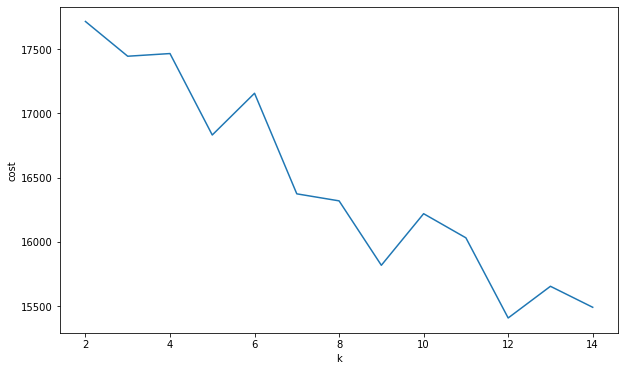

In [18]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(10,6))
ax.plot(range(2,15),cost[2:15])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [24]:
kmeans = KMeans() \
          .setK(9) \
          .setFeaturesCol("indexedFeatures")\
          .setPredictionCol("cluster")

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(dataset)
cluster = model.transform(dataset)

In [25]:
cluster.show()

+--------------------+--------------------+-------+
|            features|     indexedFeatures|cluster|
+--------------------+--------------------+-------+
|(20,[0,4,10,11,14...|(20,[0,4,10,11,14...|      0|
|[1.0,0.0,0.007302...|[1.0,0.0,0.007302...|      8|
|(20,[0,2,4,14,15,...|(20,[0,2,4,14,15,...|      0|
|[1.0,0.0,0.113433...|[1.0,0.0,0.113433...|      7|
|[0.0,1.0,0.216926...|[0.0,1.0,0.216926...|      6|
|[1.0,0.0,0.005811...|[1.0,0.0,0.005811...|      8|
|[1.0,0.0,0.0,0.0,...|[1.0,0.0,0.0,0.0,...|      8|
|(20,[0,10,11,14,1...|(20,[0,10,11,14,1...|      0|
|(20,[0,2,11,14,15...|(20,[0,2,11,14,15...|      0|
|(20,[0,3,5,6,8,14...|(20,[0,3,5,6,8,14...|      8|
|[1.0,0.0,0.0,0.0,...|[1.0,0.0,0.0,0.0,...|      0|
|(20,[0,4,9,13,14,...|(20,[0,4,9,13,14,...|      0|
|(20,[0,3,14,16,17...|(20,[0,3,14,16,17...|      0|
|[1.0,0.0,0.005913...|[1.0,0.0,0.005913...|      0|
|[1.0,0.0,0.0,0.01...|[1.0,0.0,0.0,0.01...|      0|
|(20,[0,5,9,11,12,...|(20,[0,5,9,11,12,...|      0|
|(20,[1,5,6,

In [27]:
for c in range(9):
    print("{}: {}".format(c, cluster.filter(f"cluster == {c}").count()))

0: 4457
1: 443
2: 76
3: 1
4: 6
5: 5
6: 3
7: 55
8: 802


In [28]:
kmeans = KMeans() \
          .setK(5) \
          .setFeaturesCol("indexedFeatures")\
          .setPredictionCol("cluster")

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(dataset)
cluster = model.transform(dataset)

In [29]:
for c in range(5):
    print("{}: {}".format(c, cluster.filter(f"cluster == {c}").count()))

0: 5288
1: 443
2: 76
3: 4
4: 37


In [8]:
combineddf = dfcs.join(F.broadcast(dfmt), "CustomerID")
combineddf = combineddf.fillna(0)

pddf1 = combineddf.select("*").toPandas()
pddf1columns = pddf1.columns.tolist()[:2] + pddf1.columns.tolist()[3:] + [pddf1.columns.tolist()[2]]
pddf1 = pddf1[pddf1columns]
scaler = MinMaxScaler()
pddf1[pddf1.columns[1:-1]] = scaler.fit_transform(pddf1[pddf1.columns[1:-1]])
pddf1.head()

,CustomerID,TopOrder,NumberOfOrders,TotalNumItem,AverageItemPrice,AverageOrder,AverageQuantityPerOrder,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Region
0,12670.0,0.004132,0.013752,0.027387,0.001745,0.067832,0.004389,0.000000,0.005870,0.00000,0.035897,0.008475,0.000000,0.000000,0.00000,0.005524,0.0,0.033644,0.0,Europe
1,12823.0,0.004541,0.033399,0.000000,0.004046,0.059042,0.002662,0.006354,0.013933,0.02161,0.018004,0.006841,0.006648,0.007511,0.00366,0.008325,0.0,0.034039,0.0,Domestic
2,12859.0,0.003414,0.000000,0.007825,0.001578,0.076515,0.005413,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.005224,0.0,0.000000,0.0,Domestic
3,12906.0,0.009182,0.007859,0.021127,0.001430,0.077238,0.006075,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.017591,0.0,0.017499,0.0,Domestic
4,13068.0,0.001063,0.001965,0.000000,0.001455,0.043588,0.003215,0.002517,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.003186,0.0,Domestic


In [9]:
pddf1['Region'] = pd.Categorical(pddf1['Region'])
region = pd.get_dummies(pddf1['Region'], prefix='Is', drop_first=True)
pddf1 = pd.concat([pddf1, region], axis=1).drop("Region", axis=1)
data = pddf.set_index('CustomerID').join(pddf1.set_index('CustomerID'))
data.head()

,10002,10080,10109,10120,10123C,10123G,10124A,10124G,10125,10133,...,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Is_Europe,Is_International
CustomerID,,,,,,,,,,,,,,,,,,,,,
13035.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.005349,0.004949,0.000000,0.000000,0,0
13327.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.006064,0.012324,0.012362,0.010929,0.003902,0.004115,0.030609,0.022228,0,0
13459.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
13798.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.200615,0.071432,0.078317,0.090971,0.049181,0.075633,0.126260,0.067253,0,0
14911.0,0.040431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042316,0.105263,...,0.427148,0.383691,0.316451,0.205090,0.352070,0.511590,0.678023,0.224842,1,0


In [10]:
from sklearn.cluster import KMeans as SLKMeans

sklkmeans = SLKMeans(n_clusters=5, random_state=0).fit(data)

In [11]:
for c in range(5):
    print("{}: {}".format(c, sklkmeans.labels_.tolist().count(c)))

0: 2
1: 5401
2: 1
3: 1
4: 443


In [12]:
sklkmeans = SLKMeans(n_clusters=2, random_state=0).fit(data)

for c in range(2):
    print("{}: {}".format(c, sklkmeans.labels_.tolist().count(c)))

0: 5
1: 5843


In [13]:
sklkmeans = SLKMeans(n_clusters=3, random_state=0).fit(data)

for c in range(3):
    print("{}: {}".format(c, sklkmeans.labels_.tolist().count(c)))

0: 7
1: 5840
2: 1


In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5, svd_solver='full')
pca.fit(data)
print(f"Explained Ratios: {pca.explained_variance_ratio_}")
print(f"Component Values: {pca.components_}")

Explained Ratios: [0.06563684 0.04179743 0.03544327 0.02989403 0.0242719 ]
Component Values: [[ 4.98991705e-03  5.32161421e-04  0.00000000e+00 ...  2.70233099e-02
   1.21103894e-01  4.19728329e-03]
 [ 3.93183416e-03  2.41065897e-04 -5.27355937e-16 ...  1.87842862e-05
  -3.19830082e-01 -3.23711113e-03]
 [-3.39445293e-03  7.84825815e-04  4.44089210e-16 ...  6.67676186e-03
  -9.30237786e-01  2.02227110e-02]
 [-6.01699387e-04  5.14692132e-04 -1.34180861e-15 ...  4.97550329e-03
   1.11017700e-03 -7.91629805e-03]
 [-9.67964009e-05 -4.92769043e-04  2.28753106e-16 ...  5.43101655e-02
   2.29530468e-02  3.43868242e-03]]


In [33]:
from sklearn.cluster import DBSCAN

dbcluster = DBSCAN().fit(data)
for c in list(set(dbcluster.labels_)):
    print("{}: {}".format(c, list(dbcluster.labels_).count(c)))

0: 2745
1: 206
2: 33
-1: 2864


In [15]:
from sklearn.cluster import AgglomerativeClustering

aggcluster = AgglomerativeClustering().fit(data)
for c in list(set(aggcluster.labels_)):
    print("{}: {}".format(c, list(aggcluster.labels_).count(c)))

0: 4
1: 5844
